## 导入Python包

In [1]:
import collections
import hashlib
import os
import random
import re
import requests
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from typing import Callable
import math
import numpy as np
from IPython import display
import tarfile
import time
import torch
import torchmetrics
import zipfile
import functools

## code from d2l
一些修改
1. for homework，查看没有梯度衰减的训练情况，train_ch8函数新加入一个修改梯度衰减阈值的变量
2. for homework predict函数变成抽样选取，默认取最大值

In [6]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def download(name, cache_dir=os.path.join('.', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名

    Defined in :numref:`sec_kaggle_house`"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件

    Defined in :numref:`sec_kaggle_house`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中

    Defined in :numref:`sec_text_preprocessing`"""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """统计词元的频率

    Defined in :numref:`sec_text_preprocessing`"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表

    Defined in :numref:`sec_text_preprocessing`"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列

    Defined in :numref:`sec_language_model`"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列

    Defined in :numref:`sec_language_model`"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """Defined in :numref:`sec_language_model`"""
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表

    Defined in :numref:`sec_language_model`"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

class RNNModel(torch.nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional: #如果是双向
            self.num_directions = 1
            self.linear = torch.nn.Linear(self.num_hiddens, self.vocab_size) #线性层 /输出层
        else:
            self.num_directions = 2
            self.linear = torch.nn.Linear(self.num_hiddens, self.vocab_size)
    
    def forward(self, inputs, state):
        ## batch_first relevant
        X = torch.nn.functional.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        ## batch_first relevant
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, torch.nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers, 
                                batch_size, self.num_hiddens),
                                device = device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                     torch.zeros((
                         self.num_directions * self.rnn.num_layers,
                         batch_size, self.num_hiddens), device=device))#(h_n, c_n)
                         
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def choose_max(y_like: torch.Tensor):
    return int(y_like.argmax(dim=1))

def choose_sample(y_like: torch.Tensor, alpha: int=1):
    return int(torch.distributions.categorical.Categorical(logits=y_like**alpha).sample())

def predict_ch8(prefix, num_preds, net, vocab, device, choose_method: Callable=choose_max):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.reshape(torch.tensor(
        [outputs[-1]], device=device), (1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # homework modify original: outputs.append(int(y.argmax(dim=1).reshape(1)))
        choose_method(y)
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(net, theta):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter, clip_cond):
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            ## try to fix??
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, torch.nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        updater.zero_grad()
        l.backward()
        grad_clipping(net, clip_cond)
        updater.step()
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device, choose_method: Callable=choose_max, clip_cond=1, use_random_iter=False):
    loss = torch.nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                           legend=['train'], xlim=[10,num_epochs])
    #初始化优化器
    updater = torch.optim.SGD(net.parameters(), lr)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device, choose_method)
    #训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter, clip_cond)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

## homework code for ch8 sec5

In [ ]:
#T2


困惑度 1.3, 85567.4 词元/秒 cpu
time traveller
traveller


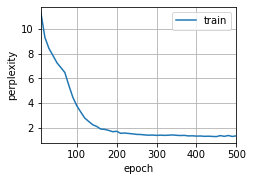

In [8]:
# T3(1)
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256)
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 500, torch.device('cpu'), choose_sample)

困惑度 1.3, 100945.4 词元/秒 cpu
time traveller
traveller


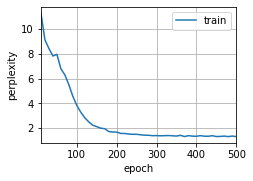

In [11]:
# T3(2)
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256)
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 500, torch.device('cpu'), functools.partial(choose_sample, alpha=2))

困惑度 1.3, 114715.0 词元/秒 cpu
time traveller
traveller


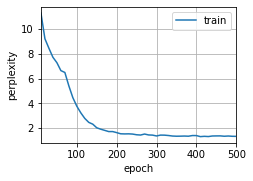

In [9]:
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256)
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 500, torch.device('cpu'), choose_max)

困惑度 202043984386602922502051321610240.0, 76135.1 词元/秒 cpu
time traveller
traveller


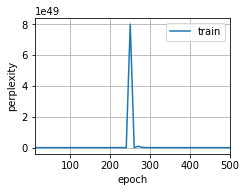

In [10]:
# T4
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256)
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 500, torch.device('cpu'), choose_max, clip_cond=torch.inf)

困惑度 1.7, 104464.4 词元/秒 cpu
time traveller
traveller


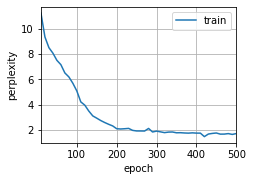

In [13]:
#T5
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256)
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 500, torch.device('cpu'), use_random_iter=True)

困惑度 1.1, 91672.5 词元/秒 cpu
time traveller
traveller


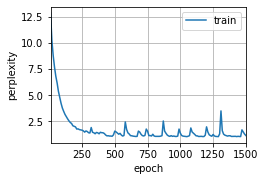

In [16]:
# T6
train_iter, vocab = load_data_time_machine(32, 35)
rnn_layer = torch.nn.RNN(len(vocab), 256, nonlinearity='relu')
net = RNNModel(rnn_layer, len(vocab))
train_ch8(net, train_iter, vocab, 1, 1500, torch.device('cpu'), clip_cond=torch.inf)

## homework code for ch8 sec6

In [2]:
#T3
def generate_timeseries(batch_size, timesteps):
    f1, f2, o1, o2 = torch.rand(4, batch_size, 1)
    t = torch.linspace(0, 1, timesteps)
    series = 0.5*torch.sin((t-o1)*(f1*10+10))
    series += 0.2*torch.sin((t-o2)*(f2*20+10))
    series += 0.1*torch.randn(batch_size, timesteps)
    return series.unsqueeze(2)

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, batch_size, timestep, nsteps, seq_to_seq=True):
        series = generate_timeseries(batch_size, timestep)
        self.X, y = series[:, :nsteps, :], series[:, nsteps:, 0]
        if seq_to_seq:
            self.y = torch.empty(batch_size, nsteps, timestep-nsteps)
            for i in range(1, timestep-nsteps+1):
                self.y[:, :, i-1] = series[:,i:i+nsteps,0]
        else:
            self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


data = TimeSeriesDataset(10000, 100, 80)
train_data, test_data = torch.utils.data.Subset(data, range(9000)), torch.utils.data.Subset(data, range(9000, 10000))
batch_size = 256
Train_data, Val_data = torch.utils.data.Subset(data, range(7200)), torch.utils.data.Subset(data, range(7200, 9000))
Train_Loader, Val_Loader = torch.utils.data.DataLoader(Train_data, batch_size=batch_size, shuffle=True), torch.utils.data.DataLoader(Val_data, batch_size=batch_size)

In [38]:
class AutoRegressor(torch.nn.Module):
    def __init__(self, in_feature, out_feature, nsteps, activation, **kwargs) -> None:
        super().__init__()
        self.rnn = torch.nn.RNN(in_feature, out_feature, **kwargs)
        self.linear = torch.nn.Linear(out_feature, nsteps)
        self.activation = activation

    def forward(self, x):
        output, _ = self.rnn(x)
        return self.activation(self.linear(output))


In [41]:
reg = AutoRegressor(1, 40, 20, torch.nn.Tanh(), batch_first=True, num_layers=1).cuda()
loss_lst = [torch.nn.MSELoss(reduction='mean'), torch.nn.L1Loss(reduction='mean')]
optimizer = torch.optim.Adam(reg.parameters(), lr=0.05)
metric = [torchmetrics.MeanAbsoluteError().cuda()]

In [42]:
for epoch in range(20):
    d = {}
    reg.train()
    for X, y in Train_Loader:
        X, y = X.cuda(), y.cuda()
        pred = reg(X)
        optimizer.zero_grad()
        for i, loss_fn in enumerate(loss_lst):
            loss = loss_fn(pred, y)/len(loss_lst)
            if i == len(loss_lst)-1:
                loss.backward()
            else:
                loss.backward(retain_graph=True)
            d.update({f'loss_{i+1}': loss.item()})
        optimizer.step()     
        for i, metric_fn in enumerate(metric):
            metric_fn.update(pred, y)
            d.update({f'metric_{i+1}: ' : metric_fn.compute().item()})
        metric_fn.reset()
    reg.eval()
    with torch.no_grad():
        for X, y in Val_Loader:
            X, y = X.cuda(), y.cuda()
            pred = reg(X)
            for i, loss_fn in enumerate(loss_lst):
                loss = loss_fn(pred, y)/len(loss_lst)
                d.update({f'val loss_{i+1}': loss.item()})
            for i, metric_fn in enumerate(metric):
                metric_fn.update(pred, y)
                d.update({f'val metric_{i+1}': metric_fn.compute().item()})
        metric_fn.reset()
    print(f'state in epoch {epoch+1}: ', d)

state in epoch 1:  {'loss_1': 0.0510200634598732, 'loss_2': 0.12735554575920105, 'metric_1: ': 0.2547110915184021, 'val loss_1': 0.05903518572449684, 'val loss_2': 0.13847874104976654, 'val metric_1': 0.2766377329826355}
state in epoch 2:  {'loss_1': 0.031995248049497604, 'loss_2': 0.09884349256753922, 'metric_1: ': 0.19768700003623962, 'val loss_1': 0.032470595091581345, 'val loss_2': 0.10190790146589279, 'val metric_1': 0.20152884721755981}
state in epoch 3:  {'loss_1': 0.029194969683885574, 'loss_2': 0.0957464799284935, 'metric_1: ': 0.191492959856987, 'val loss_1': 0.026722077280282974, 'val loss_2': 0.09241601824760437, 'val metric_1': 0.185435488820076}
state in epoch 4:  {'loss_1': 0.031421903520822525, 'loss_2': 0.0989123210310936, 'metric_1: ': 0.1978246569633484, 'val loss_1': 0.031038284301757812, 'val loss_2': 0.10005152225494385, 'val metric_1': 0.20027130842208862}
state in epoch 5:  {'loss_1': 0.03118431568145752, 'loss_2': 0.0977666825056076, 'metric_1: ': 0.19553336501